# 🔧 Configuration and Synonym Maps
This section defines static lists and synonym maps used throughout the pipeline.

In [216]:
browsers = [
    "Safari", "Chrome", "Firefox", "Edge", "Brave", "Opera",
    "Samsung Internet", "In-App Browser", "Internet Explorer 11",
    "Vivaldi", "DuckDuckGo Browser", "Tor Browser"
]

oses = [
    "macOS Ventura", "All", "Windows 10", "macOS Sonoma", "Linux Ubuntu",
    "iOS 16", "Android 13", "Chrome OS", "Windows 11", "macOS Monterey",
    "Linux Mint", "iOS 15"
]

customer_types = [
    "Enterprise", "Mixed", "SMB", "Marketing", "Individual", "Education",
    "Government", "Finance", "Retail", "Healthcare", "Non-profit", "Technology"
]

# Full browser synonym map
BROWSER_SYNONYMS = {
    "safari": ["safari", "mobile safari", "safari mobile"],
    "chrome": ["chrome", "google chrome"],
    "firefox": ["firefox", "mozilla firefox"],
    "edge": ["edge", "microsoft edge"],
    "brave": ["brave"],
    "opera": ["opera"],
    "samsung internet": ["samsung internet", "samsung browser"],
    "in-app browser": ["in-app browser", "in app browser", "app browser"],
    "internet explorer 11": ["internet explorer", "ie11", "ie 11", "internet explorer 11"],
    "vivaldi": ["vivaldi"],
    "duckduckgo browser": ["duckduckgo browser", "duck duck go", "ddg browser"],
    "tor browser": ["tor", "tor browser"],
    "internet explorer 11": ["internet explorer", "ie11", "ie 11", "internet explorer 11", "ie"],
}

# Operating-system synonym map
OS_SYNONYMS = {
    "macos ventura": ["macos ventura", "ventura", "mac os ventura", "macos 13"],
    "macos monterey": ["macos monterey", "monterey", "macos 12"],
    "macos sonoma": ["macos sonoma", "sonoma"],
    "windows 10": ["windows 10", "win10", "win 10"],
    "windows 11": ["windows 11", "win11", "win 11"],
    "linux ubuntu": ["ubuntu", "linux ubuntu"],
    "linux mint": ["mint", "linux mint"],
    "ios 15": ["ios 15", "ios15", "iphone os 15"],
    "ios 16": ["ios 16", "ios16"],
    "android 13": ["android 13", "android13"],
    "chrome os": ["chrome os", "chromebook"],
    "windows": ["windows", "win"],
}

# Customer-type synonym map
CUSTOMER_SYNONYMS = {
    "enterprise": ["enterprise", "corp", "corporate"],
    "mixed": ["mixed"],
    "smb": ["smb", "small business", "small & medium", "small & medium business"],
    "marketing": ["marketing"],
    "individual": ["individual", "personal"],
    "education": ["education", "edu", "student"],
    "government": ["government", "gov"],
    "finance": ["finance", "financial", "banking"],
    "retail": ["retail"],
    "healthcare": ["healthcare", "health care"],
    "non-profit": ["non-profit", "nonprofit", "not for profit"],
    "technology": ["technology", "tech"],
}

# Stage synonym map
STAGE_SYNONYMS = {
    'pre-login': ['pre-login', 'before login', 'initial load'],
    'captcha': ['captcha', 'challenge'],
    'post-login': ['post-authentication', 'after login', 'dashboard', 'post-login'],
    'consent': ['consent', 'oauth consent', 'consent stuck'],
    '2FA': ['two-factor', '2fa', '2 factor'],
    'loading': ['spinner', 'infinite loading']
}

# Exact match boost keywords
exact_match_boost = {
    "session": ["session", "timeout", "session expired", "cookie", "cookie issues", "kicked out", "randomly kicked out"],
    "authentication": ["login", "auth", "sso", "oauth", "password reset", "verification", "two-factor", "2fa", "account locked", "email verification failure"],
    "network": ["vpn", "firewall", "proxy", "network error", "redirect", "err_network", "certificate error"],
    "captcha": ["captcha", "captcha missing"],
    "ui": ["blank white page", "ui broken", "feature not working", "form submission failure"],
    "performance": ["performance slow", "slow", "loading", "lag", "infinite loading"],
    "error_codes": ["403 error", "404 error", "500 error"],
    "form": ["form submission failure", "form error", "submission"],
    "sync": ["data sync", "sync issue", "data sync issue"],
    "reset": ["reset", "resend verification email", "password reset"],
    "blank_page": ["blank white page", "white page", "blank page"],
    "oauth": ["oauth", "consent", "consent stuck"],
    "vpn": ["vpn", "network error", "err_network"],
    "two_factor": ["2fa", "two-factor", "two factor"],
}

BROWSER_MAP = [
    (r'\bsafari[\s-]?(\d+\.\d+)?\b', 'Safari', 1),
    (r'\bchrome[\s-]?(\d+\.\d+)?\b', 'Chrome', 1),
    (r'\b(?:firefox|ff)[\s-]?(\d+(?:\.\d+)?)?\b', 'Firefox', 1),
    (r'\b(?:edge|microsoft edge)[\s-]?(\d+\.\d+)?\b', 'Edge', 1),
    (r'\bbrave[\s-]?(\d+\.\d+)?\b', 'Brave', 1),
    (r'\bopera[\s-]?(\d+\.\d+)?\b', 'Opera', 1),
    (r'\bsamsung internet[\s-]?(\d+\.\d+)?\b', 'Samsung Internet', 1),
    (r'\bin-app browser[\s-]?(\d+\.\d+)?\b', 'In-App Browser', 1),
    (r'\b(?:internet explorer|ie)[\s-]?11\b', 'Internet Explorer 11', None),
    (r'\bvivaldi[\s-]?(\d+\.\d+)?\b', 'Vivaldi', 1),
    (r'\b(?:duckduckgo|ddg)[\s-]?browser[\s-]?(\d+\.\d+)?\b', 'DuckDuckGo Browser', 1),
    (r'\btor[\s-]?browser[\s-]?(\d+\.\d+)?\b', 'Tor Browser', 1),
]

# 📦 Imports and Initialization
Essential libraries are imported and core models are initialized.

In [217]:
import json
import csv
import os
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer
from huggingface_hub import InferenceClient
import datetime
import re
import pandas as pd
import matplotlib.pyplot as plt

from typing import List, Dict, Optional, Any

# Configuration
EMBEDDING_MODEL = "sentence-transformers/all-MiniLM-L6-v2"
LLM_MODEL = "mistralai/Mixtral-8x7B-Instruct-v0.1"
dataset_path = "support_tickets_dataset.json"
embedding_model = SentenceTransformer(EMBEDDING_MODEL)
client = InferenceClient(token=os.getenv("HF_API_TOKEN"))

def load_dataset(path: str) -> Dict:
    """
    Load the full dataset JSON and return its content as a dictionary.
    """
    with open(path, 'r') as f:
        data = json.load(f)
    return data

def load_tickets(data : Dict):
    """Load and validate support tickets"""
    try:
        tickets = data.get('tickets', [])
        return tickets
    except Exception as e:
        raise RuntimeError(f"Failed to load tickets: {str(e)}")

def embed_texts(texts):
    """Generate embeddings with cache support"""
    return embedding_model.encode(
        texts,
        convert_to_tensor=False,
        normalize_embeddings=True,
        show_progress_bar=False
    )

def build_faiss_index(embeddings):
    """Create optimized FAISS index"""
    dim = embeddings.shape[1]
    index = faiss.IndexFlatIP(dim)
    index.add(np.array(embeddings).astype('float32'))
    return index

# 📥 Dataset Loading and Embedding Utilities
Functions to load data, embed texts, and build FAISS indices.

In [218]:
from typing import Dict, Optional, List, Tuple
from fuzzywuzzy import fuzz

def _fuzzy_match(
    query: str,
    synonym_map: Dict[str, List[str]],
    threshold: int
) -> Optional[str]:
    """
    Performs fuzzy matching on the query against a synonym map.

    Args:
        query: The query string to match.
        synonym_map: A dictionary where keys are canonical forms and
                     values are lists of synonyms.
        threshold: The minimum fuzzy match score to consider a match.

    Returns:
        The canonical form of the best match, or None if no match exceeds the threshold.
    """
    best_match = None
    best_score = 0

    for canon, syns in synonym_map.items():
        for syn in syns:
            score = fuzz.partial_ratio(query.lower(), syn.lower())
            if score > threshold and score > best_score:
                best_score = score
                best_match = canon

    return best_match

In [219]:
USE_FUZZY_MATCHING = False

In [220]:
import re
from typing import Dict
from fuzzywuzzy import fuzz

# Assuming BROWSER_SYNONYMS, OS_SYNONYMS, CUSTOMER_SYNONYMS, STAGE_SYNONYMS are defined elsewhere

def extract_filters(query: str) -> Dict[str, str]:
    q = query.strip().lower()
    filters: Dict[str, str] = {}
    FUZZ_THRESHOLD = 80  # Adjust as needed

    def fuzzy_match(text, choices, threshold=FUZZ_THRESHOLD):
        best_match = None
        best_score = threshold
        for choice in choices:
            score = fuzz.partial_ratio(text, choice)
            if score > best_score:
                best_score = score
                best_match = choice
        return best_match

    # Stage detection
    if 'oauth' in q:
        filters['stage'] = 'consent'
    else:
        if USE_FUZZY_MATCHING:
            for canon, syns in STAGE_SYNONYMS.items():
                matched_syn = fuzzy_match(q, syns)
                if matched_syn:
                    filters['stage'] = canon
                    break
        else:
            for canon, syns in STAGE_SYNONYMS.items():
                if any(s in q for s in syns):
                    filters['stage'] = canon
                    break

    for pat, name, version_group in BROWSER_MAP:
        m = re.search(pat, q)
        if m:
            filters['browser'] = name
            if version_group and m.group(version_group):
                filters['browser_version'] = m.group(version_group)
            break
    else:
        # Fallback via synonyms
        if USE_FUZZY_MATCHING:
            for canon, syns in BROWSER_SYNONYMS.items():
                matched_syn = fuzzy_match(q, syns)
                if matched_syn:
                    filters['browser'] = canon
                    break
   

    # OS detection: specific variants first
    for specific in ["macos monterey", "macos sonoma", "macos ventura", "linux mint", "linux ubuntu"]:
        if USE_FUZZY_MATCHING:
            matched_syn = fuzzy_match(q, OS_SYNONYMS[specific])
            if matched_syn:
                filters['os'] = specific
                break
        else:
            if any(s in q for s in OS_SYNONYMS[specific]):
                filters['os'] = specific
                break
    else:
        # Fallback to any OS
        for canon, syns in OS_SYNONYMS.items():
            if USE_FUZZY_MATCHING:
                matched_syn = fuzzy_match(q, syns)
                if matched_syn:
                    filters['os'] = canon
                    break
            else:
                if any(s in q for s in syns):
                    filters['os'] = canon
                    break

    # Customer type via synonyms
    for canon, syns in CUSTOMER_SYNONYMS.items():
        if USE_FUZZY_MATCHING:
            matched_syn = fuzzy_match(q, syns)
            if matched_syn:
                filters['customer_type'] = canon
                break
        else:
            if any(s in q for s in syns):
                filters['customer_type'] = canon
                break

    # Network/VPN context
    if re.search(r'\bvpn\b', q):
        filters.setdefault('network', 'VPN')
        filters.setdefault('stage', 'network')

    # Error codes
    if ec := re.search(r'\b(ERR_[A-Z_]+|\d{3})\b', query, re.IGNORECASE):
        filters['error_code'] = ec.group(1)

    # Time context
    if re.search(r'\b(today|recent|just started)\b', q):
        filters['time_context'] = 'recent'
    elif re.search(r'\b(always|constantly|persistent)\b', q):
        filters['time_context'] = 'persistent'

    # Generic stage inference if none set
    if 'stage' not in filters:
        if 'performance' in q and 'loading' in q:
            filters['stage'] = 'post-login'
        elif any(x in q for x in ['login failure', 'login issues']):
            filters['stage'] = 'SSO-redirect' if 'sso' in q else 'authentication'
        elif 'captcha' in q:
            filters['stage'] = 'captcha'
        elif 'form' in q:
            filters['stage'] = 'post-login'
        elif any(x in q for x in ['lockout', 'locked']):
            filters['stage'] = 'pre-login'
        elif 'reset' in q:
            filters['stage'] = 'password-reset'
        elif 'oauth' in q:
            filters['stage'] = 'consent'

    return filters

# 🧠 Metadata Extraction from Queries
Logic to extract filters from natural language queries using regex and synonyms.

In [221]:
import faiss
import numpy as np
import re
from typing import List, Dict, Optional, Any

class RAGSearchIndex:
    def __init__(
        self,
        tickets: List[Dict[str, Any]],
        embed_func,
        prepare_text_func,
        normalize_filters: bool = True,
    ):
        self.tickets = tickets
        self.embed = embed_func
        self.prepare_text = prepare_text_func
        self.normalize_filters = normalize_filters

        # Precompute once
        self.texts = self.prepare_text(self.tickets)
        self.embeddings = self.embed(self.texts).astype("float32")
        dim = self.embeddings.shape[1]
        self.index = faiss.IndexFlatIP(dim)
        self.index.add(self.embeddings)

    def _apply_metadata_filter(self, candidates: List[int], filters: Dict[str, str]) -> List[int]:
        if not filters:
            return candidates
        out = []
        for idx in candidates:
            ticket = self.tickets[idx]
            ok = True
            for key, val in filters.items():
                if val.lower() == "all" and self.normalize_filters:
                    continue
                tv = str(ticket.get(key, "")).lower()
                if key == "browser":
                    if val.lower() not in tv:
                        ok = False
                elif key == "os":
                    filter_os = val.lower()
                    ticket_os_group = next(
                        (k for k, syns in OS_SYNONYMS.items() if any(tv.startswith(s) for s in syns)),
                        ""
                    )
                    if not ticket_os_group.startswith(filter_os):
                        ok = False
                else:
                    if tv != val.lower():
                        ok = False
                if not ok:
                    break
            if ok:
                out.append(idx)
        return out

    def search(
        self,
        query: str,
        filters: Optional[Dict[str, str]] = None,
        top_k: int = 5,
        boost_terms: Optional[Dict[str, List[str]]] = None,
        base_threshold: float = 0.15,
        rerank_weights: Dict[str, float] = {"sim": 0.6, "overlap": 0.4},
    ) -> List[Dict[str, Any]]:
        # 1. Embed + conditional boost
        q_vec = self.embed([query])[0]
        if boost_terms:
            boosts = [
                self.embed([term])[0]
                for group in boost_terms.values()
                for term in group
                if term in query.lower()
            ]
            if len(boosts) >= 2:
                boost_mean = np.mean(boosts, axis=0)
                q_vec = 0.7 * q_vec + 0.3 * boost_mean

        # 2. Semantic search
        fetch_k = min(len(self.texts), top_k * 5)
        sims, idxs = self.index.search(np.array([q_vec], dtype="float32"), fetch_k)
        sims, idxs = sims[0], idxs[0].tolist()

        # 3. Fallback to pure semantic rerank if no filters or low confidence
        if not filters or (sims.size > 0 and sims[0] < base_threshold):
            # gather candidates above threshold (or top_k if none)
            sem_cand = [(i, s) for i, s in zip(idxs, sims) if s >= base_threshold]
            if not sem_cand:
                sem_cand = list(zip(idxs, sims))[:top_k]
            # rerank by sim + token overlap
            q_tokens = set(query.lower().split())
            reranked = []
            for i, s in sem_cand:
                tokens = set(self.texts[i].lower().split())
                overlap = len(q_tokens & tokens) / max(len(q_tokens), 1)
                score = rerank_weights["sim"] * s + rerank_weights["overlap"] * overlap
                reranked.append((i, score))
            reranked.sort(key=lambda x: x[1], reverse=True)
            final_idxs = [i for i, _ in reranked[:top_k]]
        else:
            # 4. Metadata filter
            filt_idxs = self._apply_metadata_filter(idxs, filters)
            if not filt_idxs:
                final_idxs = idxs[:top_k]
            else:
                # 5. Threshold after filtering
                cand = [(i, s) for i, s in zip(filt_idxs, sims[: len(filt_idxs)]) if s >= base_threshold]
                if not cand:
                    final_idxs = idxs[:top_k]
                else:
                    # 6. Rerank by sim + overlap
                    q_tokens = set(query.lower().split())
                    reranked = []
                    for i, s in cand:
                        tokens = set(self.texts[i].lower().split())
                        overlap = len(q_tokens & tokens) / max(len(q_tokens), 1)
                        score = rerank_weights["sim"] * s + rerank_weights["overlap"] * overlap
                        reranked.append((i, score))
                    reranked.sort(key=lambda x: x[1], reverse=True)
                    final_idxs = [i for i, _ in reranked[:top_k]]

        # 7. Dedupe by issue field
        seen, results = set(), []
        for idx in final_idxs:
            ticket = self.tickets[idx]
            issue = ticket.get("issue")
            if issue in seen:
                continue
            seen.add(issue)
            results.append(ticket)

        return results


In [222]:
def prepare_corpus(tickets):
    """Include resolutions in the searchable text"""
    texts = []
    for t in tickets:
        text = (f"Title: {t['title']}. "
                f"Issue: {t['issue']}. "
                f"Resolution: {t['resolution']} "
                f"(Browser: {t['browser']}, OS: {t['os']}, Customer: {t['customer_type']})")
        texts.append(text)
    return texts

def save_feedback(query, ticket_text, feedback):
    """Save user feedback for ticket relevance to a CSV file."""
    feedback_file = "feedback.csv"
    file_exists = os.path.isfile(feedback_file)
    
    with open(feedback_file, mode="a", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        
        # Add header if file is new
        if not file_exists:
            writer.writerow(["Query", "Ticket", "Feedback", "Timestamp"])  # <-- HERE
        
        # Add data row with timestamp
        writer.writerow([
            query,
            ticket_text,
            feedback,
            datetime.datetime.now().isoformat()
        ])

In [223]:
def evaluate_query(searcher: RAGSearchIndex, query: str, expected: List[str], top_k: int = 5) -> Dict:
    filters = extract_filters(query)
    print(query)
    print(filters)
    result = searcher.search(query, filters, top_k = 5, boost_terms = exact_match_boost, base_threshold=0.3)
    
    retrieved = [r['id'] for r in result]
    retrieved_set = set(retrieved)
    expected_set = set(expected)

    tp = len(retrieved_set & expected_set)
    fp = len(retrieved_set - expected_set)
    fn = len(expected_set - retrieved_set)

    precision = tp / (tp + fp) if tp + fp > 0 else 0.0
    recall = tp / (tp + fn) if tp + fn > 0 else 0.0
    f1 = (2 * precision * recall / (precision + recall)) if precision + recall > 0 else 0.0

    return {
        'query': query,
        'expected': expected,
        'retrieved': retrieved,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    

In [224]:
# Visualize performance
def visualize_results(df: pd.DataFrame):
    # Bar chart for F1 scores per query
    plt.figure()
    plt.barh(df['query'], df['f1'])
    plt.xlabel('F1 Score')
    plt.title('F1 Score per Query')
    plt.tight_layout()
    plt.show()

    # Line plots for precision & recall
    plt.figure()
    plt.plot(df['query'], df['precision'], label='Precision')
    plt.plot(df['query'], df['recall'], label='Recall')
    plt.xticks(rotation=90)
    plt.legend()
    plt.ylabel('Score')
    plt.title('Precision & Recall per Query')
    plt.tight_layout()
    plt.show()

    # Histogram of F1 distribution
    plt.figure()
    plt.hist(df['f1'], bins=10)
    plt.xlabel('F1 Score')
    plt.title('Distribution of F1 Scores')
    plt.tight_layout()
    plt.show()


In [225]:
top_k = 7

data = load_dataset("support_tickets_dataset.json")
tickets = load_tickets(data)

searcher = RAGSearchIndex(tickets, embed_texts, prepare_corpus, True)

results = []

for item in data.get('queries', []):
    query = item['query']
    expected = item['expected_ids']
    res = evaluate_query(searcher, query, expected, top_k)
    results.append(res)

SSO redirect failure on Safari 16.3 macOS Ventura Enterprise
{'browser': 'Safari', 'browser_version': '16.3', 'os': 'macos ventura', 'customer_type': 'enterprise'}
Infinite captcha spinner in Firefox 98 on Linux Government
{'stage': 'captcha', 'browser': 'Firefox', 'browser_version': '98', 'customer_type': 'government'}
Blank white page post-authentication in Brave on macOS Monterey
{'stage': 'post-login', 'browser': 'Brave', 'os': 'macos monterey'}
OAuth consent hang on Tor Browser Linux Mint Non-profit
{'stage': 'consent', 'browser': 'Tor Browser', 'os': 'linux mint', 'customer_type': 'non-profit'}
VPN breaks login Opera Windows Finance
{'browser': 'Opera', 'os': 'windows', 'customer_type': 'finance', 'network': 'VPN', 'stage': 'network'}
Two-factor authentication failure on Edge Windows SMB
{'stage': '2FA', 'browser': 'Edge', 'os': 'windows', 'customer_type': 'smb'}
Form submission failure in In-App Browser Marketing Android
{'browser': 'In-App Browser', 'customer_type': 'marketing'

In [228]:
results

[{'query': 'SSO redirect failure on Safari 16.3 macOS Ventura Enterprise',
  'expected': ['T001'],
  'retrieved': ['T001'],
  'tp': 1,
  'fp': 0,
  'fn': 0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0},
 {'query': 'Infinite captcha spinner in Firefox 98 on Linux Government',
  'expected': ['T004'],
  'retrieved': ['T004', 'T014', 'T006'],
  'tp': 1,
  'fp': 2,
  'fn': 0,
  'precision': 0.3333333333333333,
  'recall': 1.0,
  'f1': 0.5},
 {'query': 'Blank white page post-authentication in Brave on macOS Monterey',
  'expected': ['T011'],
  'retrieved': ['T011'],
  'tp': 1,
  'fp': 0,
  'fn': 0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0},
 {'query': 'OAuth consent hang on Tor Browser Linux Mint Non-profit',
  'expected': ['T014'],
  'retrieved': ['T014'],
  'tp': 1,
  'fp': 0,
  'fn': 0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0},
 {'query': 'VPN breaks login Opera Windows Finance',
  'expected': ['T013'],
  'retrieved': ['T013', 'T003', 'T017', 'T009'],
  'tp': 1,
  'f

Average Precision: 0.7546296296296295
Average Recall: 0.7916666666666667
Average F1: 0.7093915343915345


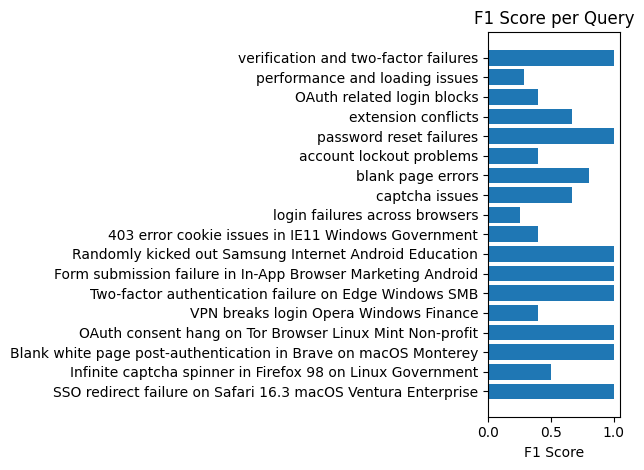

C:\Users\yatin\AppData\Local\Temp\ipykernel_24728\2894999562.py:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


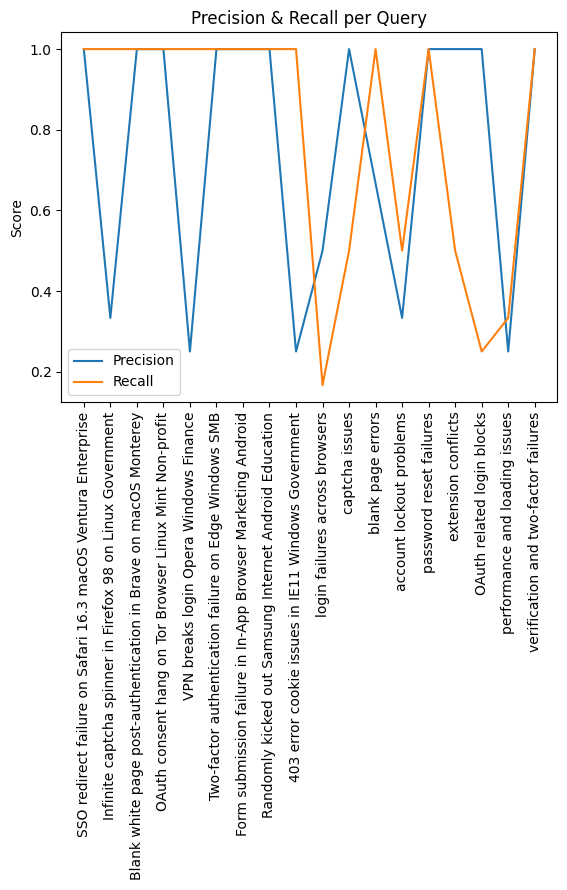

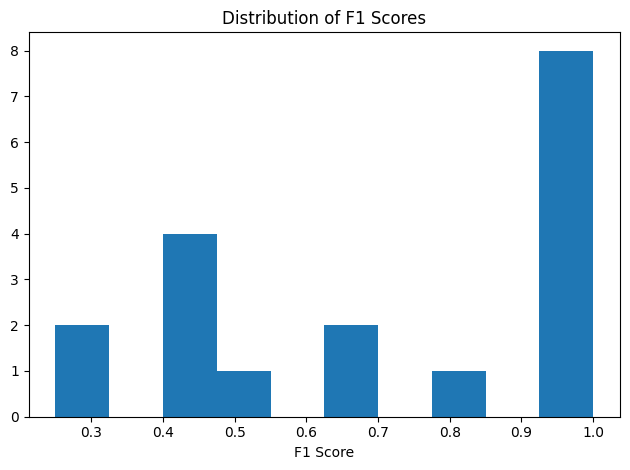

In [227]:
df = pd.DataFrame(results)
print('Average Precision:', df['precision'].mean())
print('Average Recall:', df['recall'].mean())
print('Average F1:', df['f1'].mean())

# Visualize
visualize_results(df)